# Reconocimiento estadístico de patrones
## Procesamiento de imágenes
    

In [1]:
#Cargar librerias
library(jpeg)
library(rgl)
library(grid)
library(stats)
library(kernlab)
set.seed(3)

### 1 . Leer y visualizar una imagen

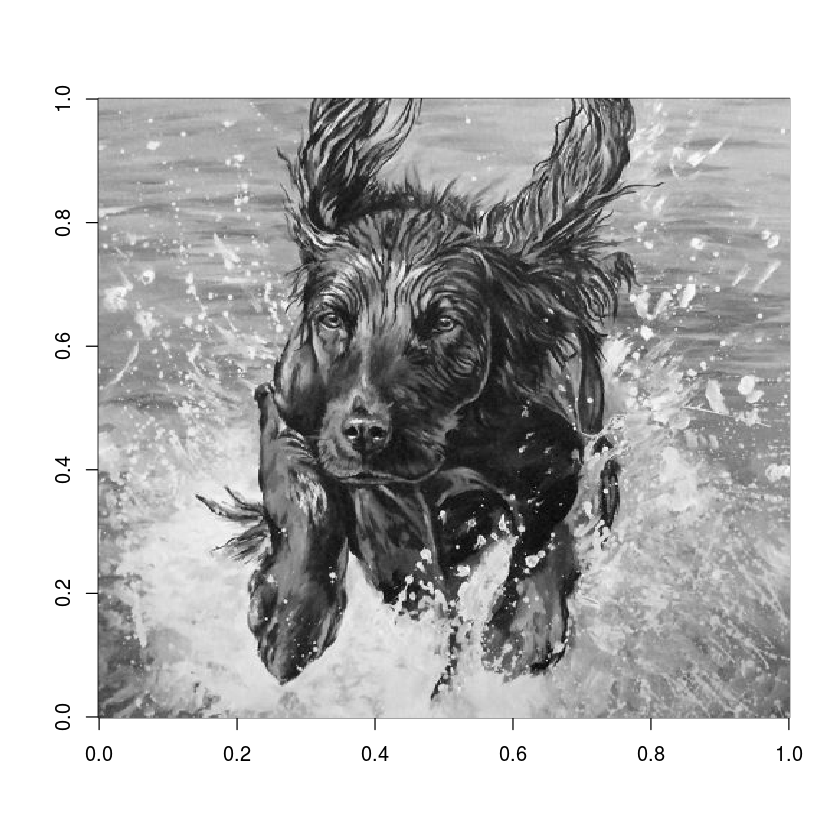

In [2]:
#Leer imagen
img<-readJPEG("dog.jpg")
imgGray<-0.3*img[,,1]+0.59*img[,,2]+0.11*img[,,3]
#Transformar la imagen
imgGray <- t(apply(imgGray, 2, rev))
# Visualizar
image(imgGray,col=gray((0:255)/255))

## 1. Visualización de pixeles

### Podemos visualizar los pixeles de la imagen a color como puntos en 3D, donde cada dimensión corresponde a un canal.

In [3]:
open3d() 
x <- img[,,1]
y <- img[,,2]
z <- img[,,3] 
plot3d(x, y, z, col='blue') 

glX 
  1

In [4]:
rgl.close()

### 1.1. Haz un histograma de la imagen en blanco y negro y agrega una estimación no paramétrica de la densidad.

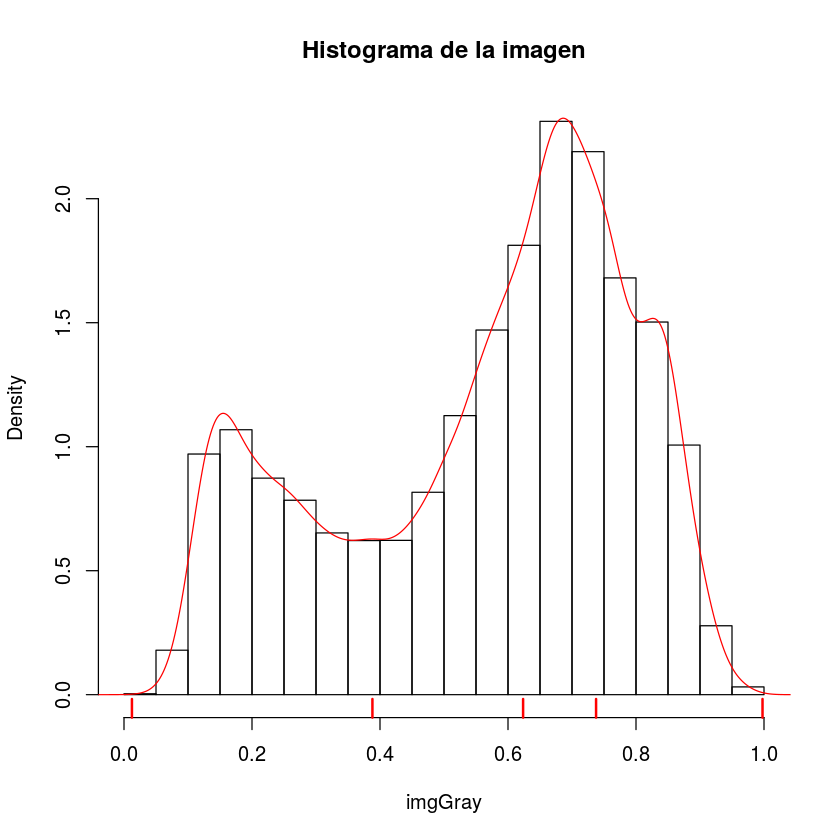

In [5]:
hist(imgGray, freq = FALSE, main = 'Histograma de la imagen')
rug(quantile(imgGray), col= 2, lwd = 2)
lines(density(imgGray), col = 2)

### 1.2. Toma un renglón de la imagen en blanco y negro, $X_i$,  visualiza $X_{i,j}$ contra $X_{i, j+1}$

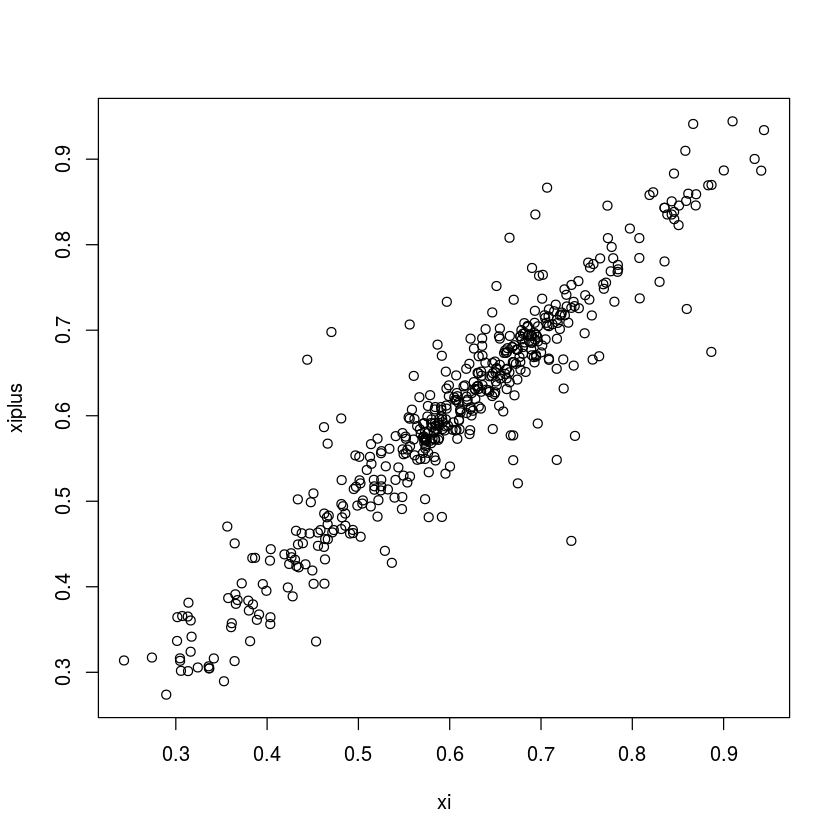

In [6]:
n<-nrow(imgGray)
i<-1
xi<-imgGray[i,1:n-1]
xiplus<-imgGray[i,2:n]
plot(xi, xiplus)

### Plus: visualiza $X_{i,j}$ contra $X_{i, j+ k}$ con $k = 1,2,3,4$. ¿Qué observas? 

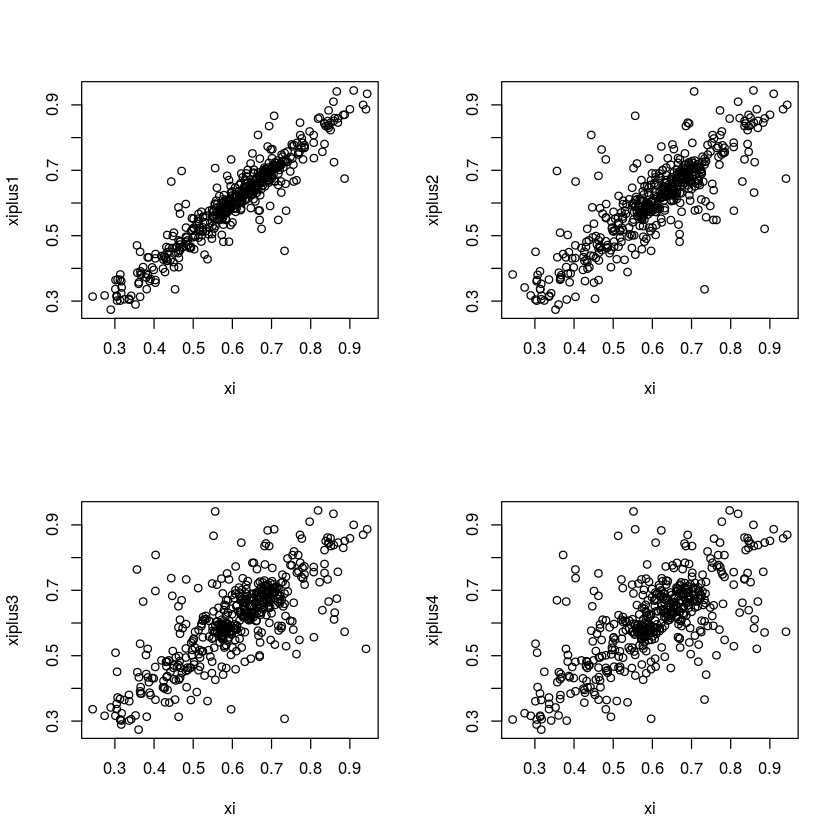

In [7]:
i<-1
par(mfrow = c(2,2))
for (k in 1:4){
    xi<-imgGray[i,1:(n-k)]
    xiplus<-imgGray[i,(k+1):n]
    plot(xi, xiplus, xlab = 'xi', ylab = paste('xiplus',k, sep = ""))
}

### 1.3 Agrega ruido gaussiano a la imagen y visualiza los resultados. Calcula la entropia de la imagen original y la imagen modificada.

[1] "Entropia de la imagen original: 13.429026484053  "
[1] "Entropia de la imagen con ruido: 17.813781191217  "


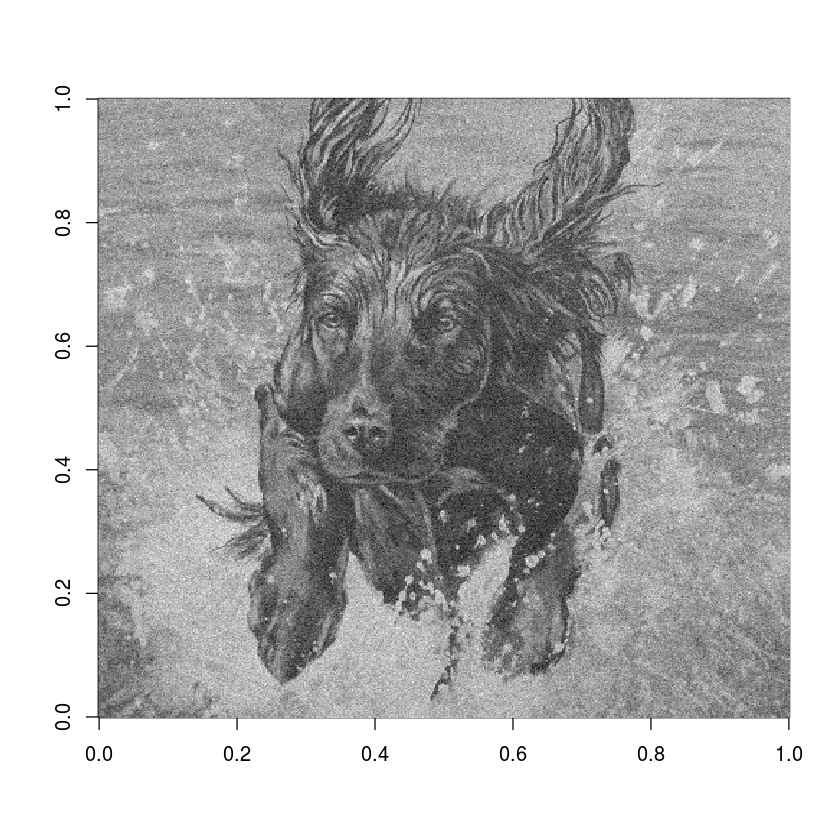

In [8]:
## Agregamos ruido gaussiano a la imagen
imgN<-imgGray + matrix(rnorm(n*n,0,0.1), nrow= n,ncol = n)
image(imgN,col=gray((0:255)/255))

freqs <- table(imgGray)/length(imgGray)
vec <- as.data.frame(freqs)[,2]
entOrig<--sum(vec * log2(vec))

freqsN <- table(imgN)/length(imgN)
vecN <- as.data.frame(freqsN)[,2]
entNoise<--sum(vecN * log2(vecN))

print(paste("Entropia de la imagen original:", entOrig, " "))
print(paste("Entropia de la imagen con ruido:", entNoise , " "))

## 2. Segmentación usando k medias

### Una manera de segmentar una imagen en k diferentes niveles de griz consiste en utilizar el algoritmo k-medias y cambiar el nivel de gris en un pixel por el nivel de gris del centroide del cluster al cual pertenece.

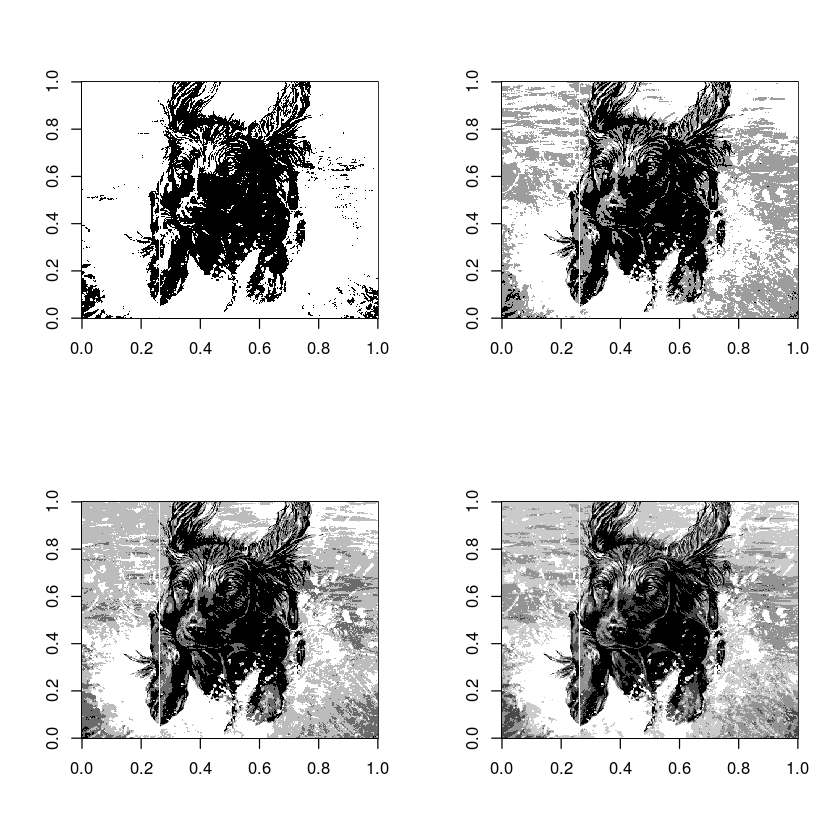

In [9]:
##Ejemplo de segmentacion usando k-medias
#Show image for k in {2,3,4,5}
par(mfrow = c(2,2))
for (k in 2:5){
	km<-kmeans(as.vector(imgGray), k)
	cluster<-km$cluster
	for (l in 1:k){
		cluster<-replace(cluster, cluster == l, km$centers[l])
	}
	centerValM<-matrix(cluster, n, n)
    image(centerValM,col=gray((0:255)/255))
}


### 2.1 ¿Cómo determinar el número de grupos?

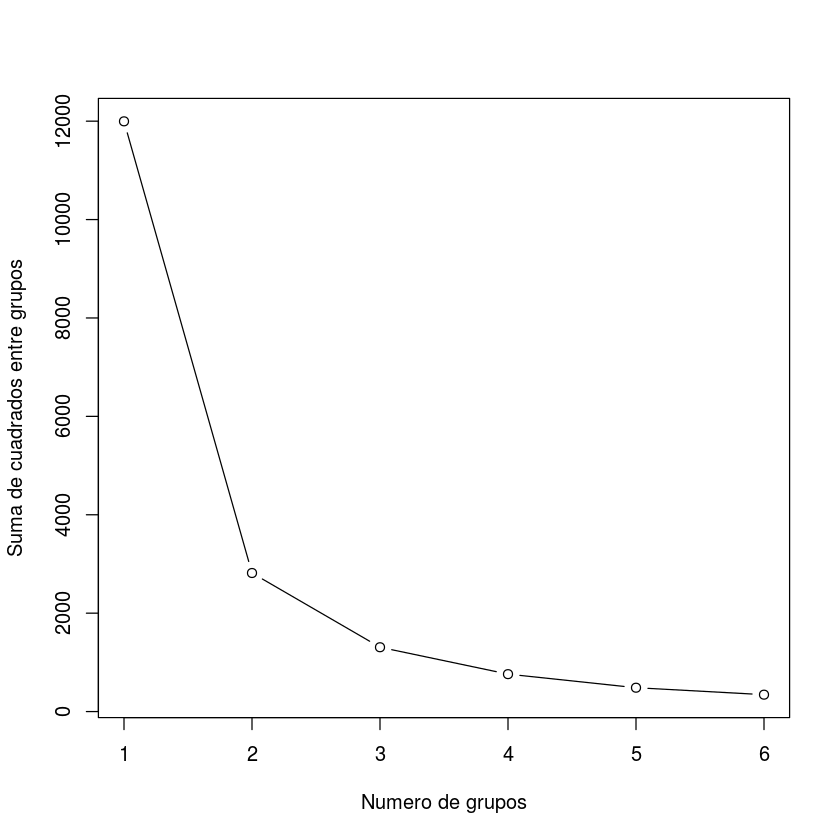

In [10]:
wss <- rep(0, 6)
wss[1] <- (n*n - 1) * sum(var(as.vector(imgGray)))
for (i in 2:6){
    wss[i] <- sum(kmeans(as.vector(imgGray),centers = i)$withinss)
}
plot(1:6, wss, type = "b", xlab = "Numero de grupos",
ylab = "Suma de cuadrados entre grupos")


### 2.2. ¿Cómo utilizarías esta técnica para imágenes a color? 

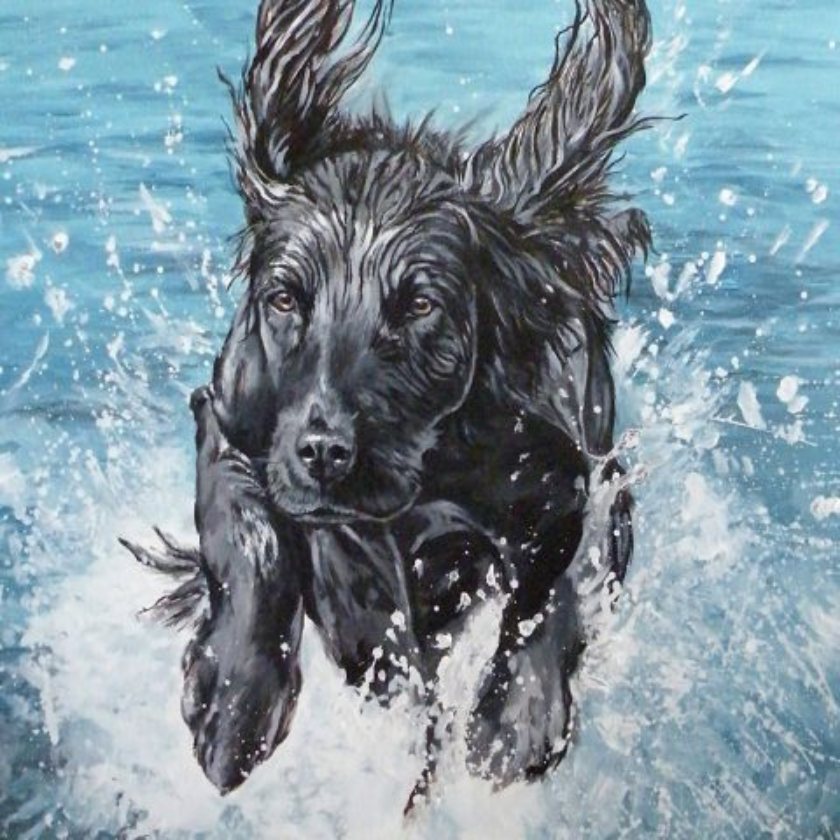

In [11]:
grid.raster(img)
data<-cbind(as.vector(img[,,1]),as.vector(img[,,2]),as.vector(img[,,3]))

In [12]:
k <- 3
km<-kmeans(data, k)
clusterR<-km$cluster
clusterG<-km$cluster
clusterB<-km$cluster

for (l in 1:k){
    clusterR<-replace(clusterR, clusterR == l, km$centers[l,1])
    clusterG<-replace(clusterG, clusterG == l, km$centers[l,2])
    clusterB<-replace(clusterB, clusterB == l, km$centers[l,3])
}

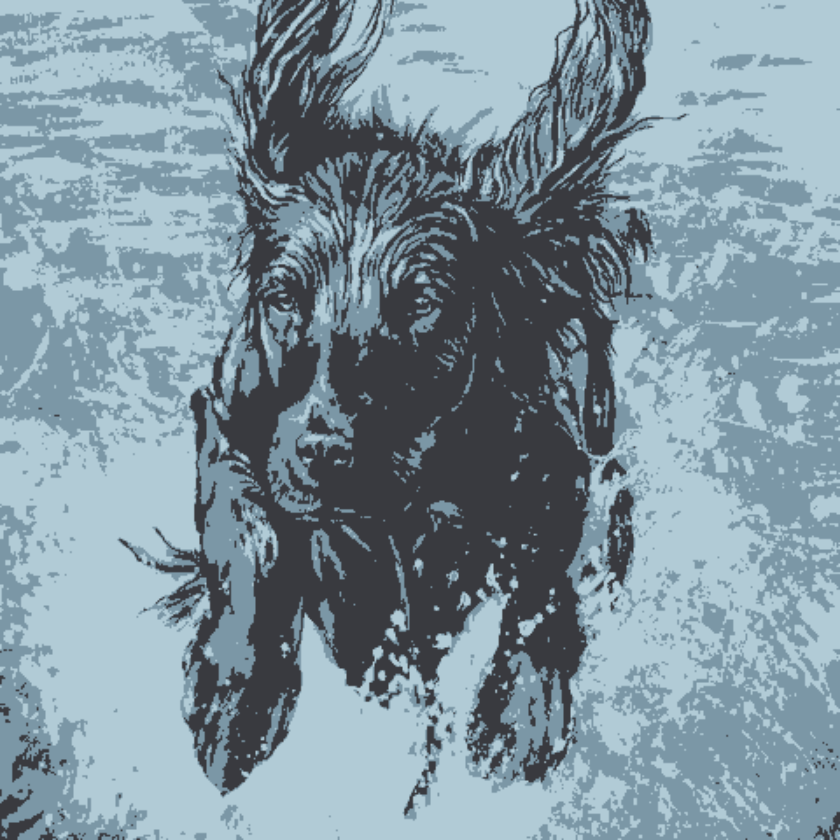

In [13]:
R<-matrix(clusterR, n, n)
G<-matrix(clusterG, n, n)
B<-matrix(clusterB, n, n)

segmentedImg<-array(dim=dim(img))
segmentedImg[,,1]<-R
segmentedImg[,,2]<-G
segmentedImg[,,3]<-B

grid.raster(segmentedImg)

## 3. Compresión de imágenes

### 3.1 Compresión usando SVD

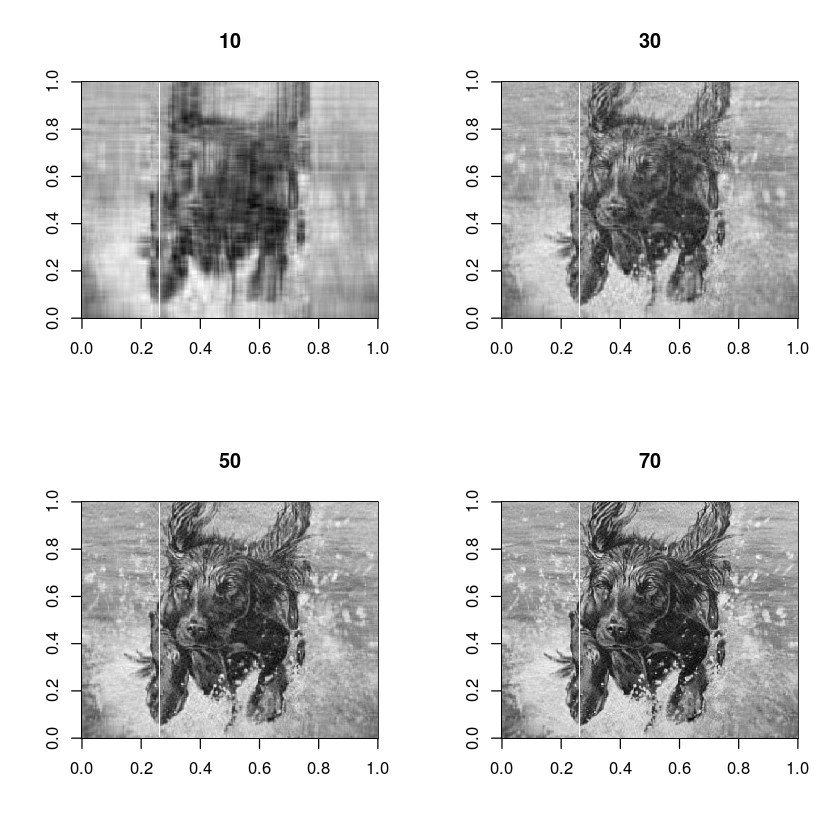

In [14]:
#Hacemos SVD de la imagen en blanco y negro
svdImg<-svd(imgGray)
d <- svdImg$d
u <- svdImg$u
v <- svdImg$v
par(mfrow = c(2,2))
#Hacemos la reconstruccion utilizando i valores propios  vectores propios
for (i in seq(10,70,20)){
    compressedImg<- u[,1:i] %*% diag(d[1:i]) %*% t(v[,1:i])
    image(compressedImg, col = gray((0:255)/255), main = i)
}

### 3.2. Compresión usando PCA
### Consiste en dividir la imagen en bloques de cxc pixeles. Con los valores de cada bloque se forma un vector y se agrupan en una matriz de datos. La compresión consiste en proyectar los datos sobre los primeros k componentes principales. La decompresión consiste en reconstruir los datos a partir de estas proyecciones. 

In [15]:
#FUNCIONES AUXILIARES
# Divide la una imagen en bloques de cxc
mat_split <- function(M, c){
	sizeCol <-ncol(M)/c
	sizeRow <-nrow(M)/c
	splitByCol<-lapply(1:c, function(x) {M[, ((x-1)*(sizeCol)+1):(x*sizeCol)]})
	splitByColRow<-lapply(splitByCol, function(mat){ 	
		lapply(1:c, function(x) {
			mat[((x-1)*(sizeRow)+1):(x*sizeRow), ]
		})
	})	
	return(splitByColRow)
}


#Recibe una lista de matrices y devuelve una lista de vectores
unrollMatrices<-function(matList){
	lapply(1:length(matList), function(y) {
		lapply(1:length(matList[[y]]), function(x) {c(t(matList[[y]][[x]]))})	
	})
}

#Recibe una lista de vectores y devuelve una matriz
vecsToMat<-function(vecList){
	res<-matrix(unlist(vecList), byrow = TRUE, ncol=length(vecList[[1]][[1]]))
	return(res)
}

#Reconstrucción de la imagen
#Recibe una matriz de componentes y devuelve la matriz con la imagen
matToImage<-function(matrixC){
	c<-sqrt(ncol(matrixC))
	imageList<-lapply(1:nrow(matrixC), function(x) {matrix(matrixC[x,], byrow=TRUE, ncol = c)})
	nImages<-sqrt(length(imageList))
	matImg<-lapply(0:(nImages-1), function(y) {
			do.call(rbind, imageList[seq(nImages*y+1, nImages*(y+1))])
	})
	res<-do.call(cbind, matImg)
	return(res)
}


### Realiza la compresión de la imágen usando el procedimiento mencionado anteriormente. Puedes usar las funciones auxiliares

In [16]:
matList<-mat_split(imgGray,10)
vecList<-unrollMatrices(matList)
matGrid<-vecsToMat(vecList)
pca_img<-princomp(t(matGrid))
summary(pca_img)

Importance of components:
                          Comp.1     Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     0.6722908 0.44842228 0.40116244 0.30815581 0.30294414
Proportion of Variance 0.2034761 0.09052603 0.07245021 0.04275036 0.04131657
Cumulative Proportion  0.2034761 0.29400215 0.36645236 0.40920272 0.45051929
                          Comp.6     Comp.7     Comp.8    Comp.9   Comp.10
Standard deviation     0.2662409 0.25054626 0.23807773 0.2167478 0.2051447
Proportion of Variance 0.0319116 0.02826018 0.02551741 0.0211499 0.0189461
Cumulative Proportion  0.4824309 0.51069107 0.53620848 0.5573584 0.5763045
                          Comp.11    Comp.12   Comp.13    Comp.14    Comp.15
Standard deviation     0.19978529 0.19322335 0.1876705 0.17890430 0.17805507
Proportion of Variance 0.01796909 0.01680809 0.0158559 0.01440923 0.01427275
Cumulative Proportion  0.59427357 0.61108166 0.6269376 0.64134679 0.65561954
                         Comp.16    Comp.17   Comp.18    C

### 3.3 ¿Cómo influye el valor de k en la calidad de la reconstruccion?

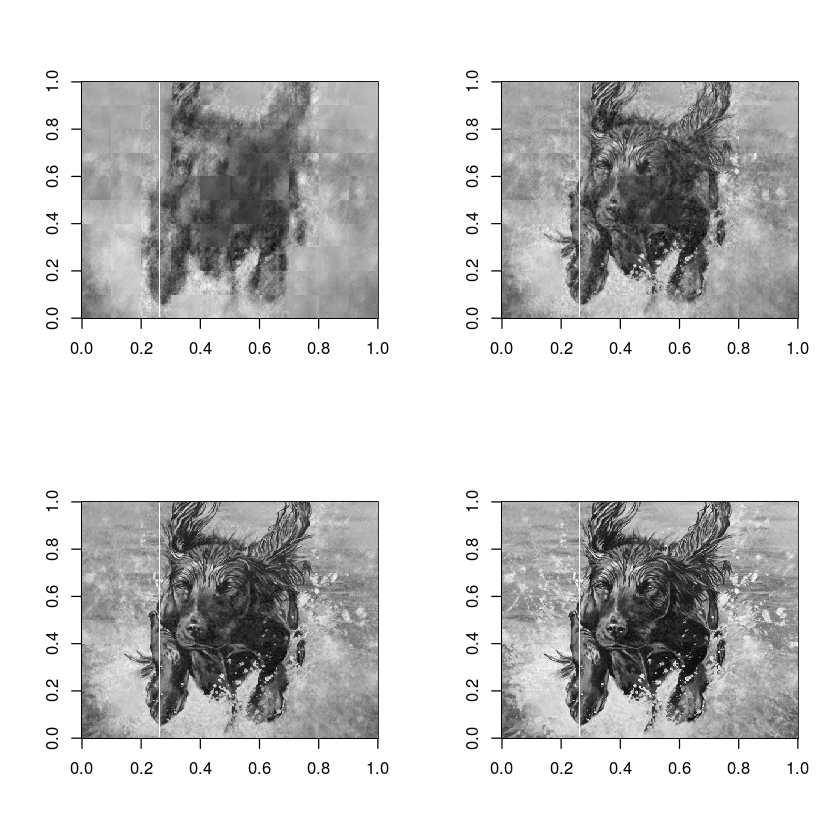

In [17]:
#Reconstruction
par(mfrow = c(2,2))
#Hacemos la reconstruccion utilizando i valores propios  vectores propios
for (i in seq(10, 70, 20)){
    im<-pca_img$scores[,1:i]%*%t(pca_img$loadings[,1:i])
    #Agregamos la media
    im<-im + matrix(rep(colMeans(t(matGrid)), each = nrow(pca_img$scores)), nrow = nrow(pca_img$scores))
    im1<-matToImage(t(im))
    image(im1, col=gray((0:255)/255))
}

## 4. Segmentación usando spectral clustering

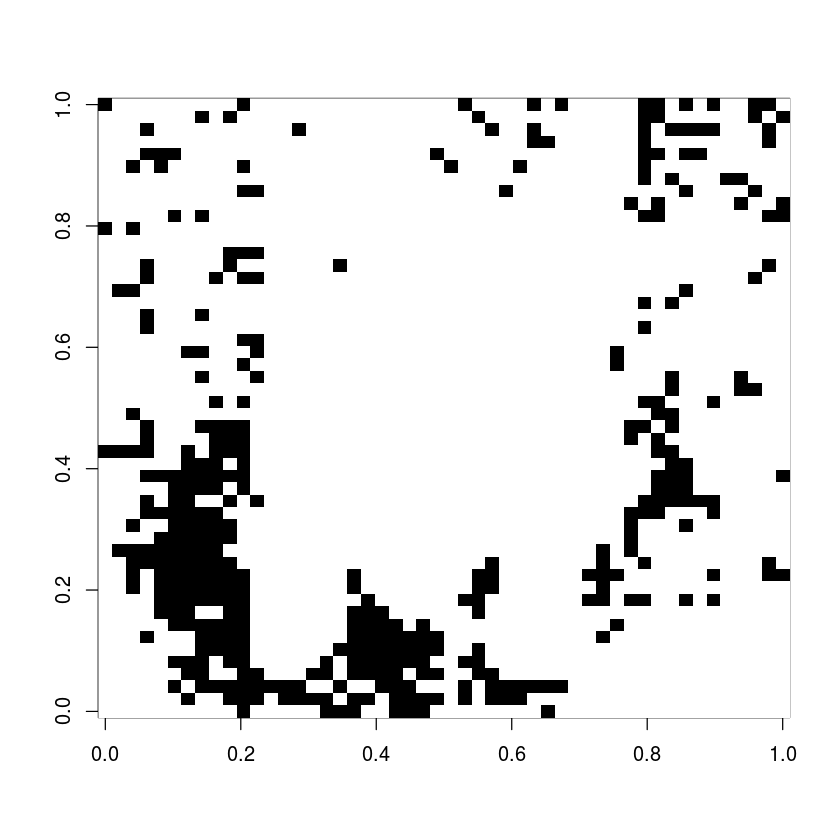

In [18]:
# Creamos un grafo donde cada nodo es un dato. 
img<-readJPEG("dogSmall.jpg")
imgGray<-0.3*img[,,1]+0.59*img[,,2]+0.11*img[,,3]
imgGray <- t(apply(imgGray, 2, rev))
data<-as.vector(imgGray)
# #Definimos wij como la similitud entre el nodo i y el nodo j. 
k<-kernelMatrix(rbfdot(sigma = sd(data)),data)

# En el grafo solo vamos a conectar los grafos con similitud alta
getAdjMat<-function(k, nneighbors){
    n<-nrow(k)
    adjMat <- matrix(rep(0,n^2), ncol=n)
    for(i in 1:n) {
      nearestNodes <- sort(k[i,], decreasing=TRUE)[1:nneighbors]
      for (s in nearestNodes) {
        j <- which(k[i,] == s)
        adjMat[i,j] <- k[i,j]
        adjMat[j,i] <- k[i,j] 
      }
    }
  return(adjMat)   
}

#Matriz de adyacencia
W<-getAdjMat(k, 10)
# Matriz diagonal
D<-diag(apply(W, 1, sum))

#Laplaciano normalizado
L <-D-W
eig<-eigen(L)
Z   <- eig$vectors[,nrow(k)-1]
ncentroids<-2
km <- kmeans(Z, centers=ncentroids)
centerValM<-matrix(km$cluster-1, nrow(imgGray), ncol(imgGray))
image(centerValM,col=gray((0:255)/255))